Data Shape: (6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Class Distribution:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64
Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.97      1.00      0.98      2464

    accuracy                           1.00    831123
   macro avg       0.99      1.00      0.99    831123
weighted avg       1.00      1.00 

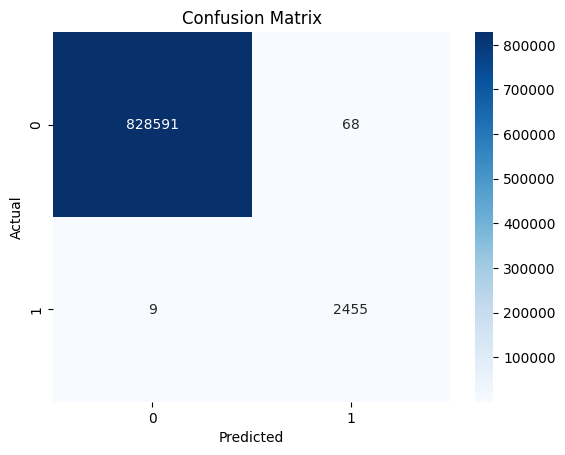

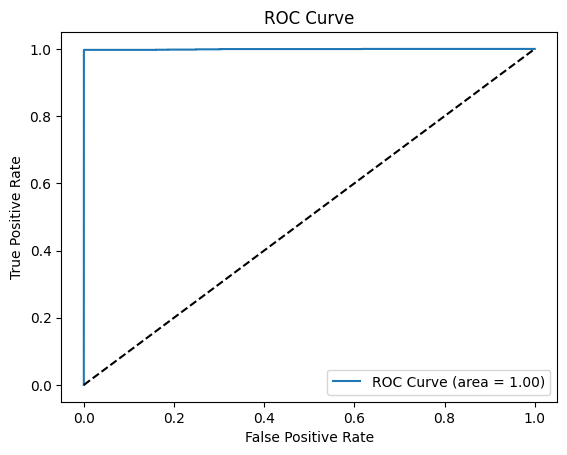


ROC AUC Score: 0.99916114199913


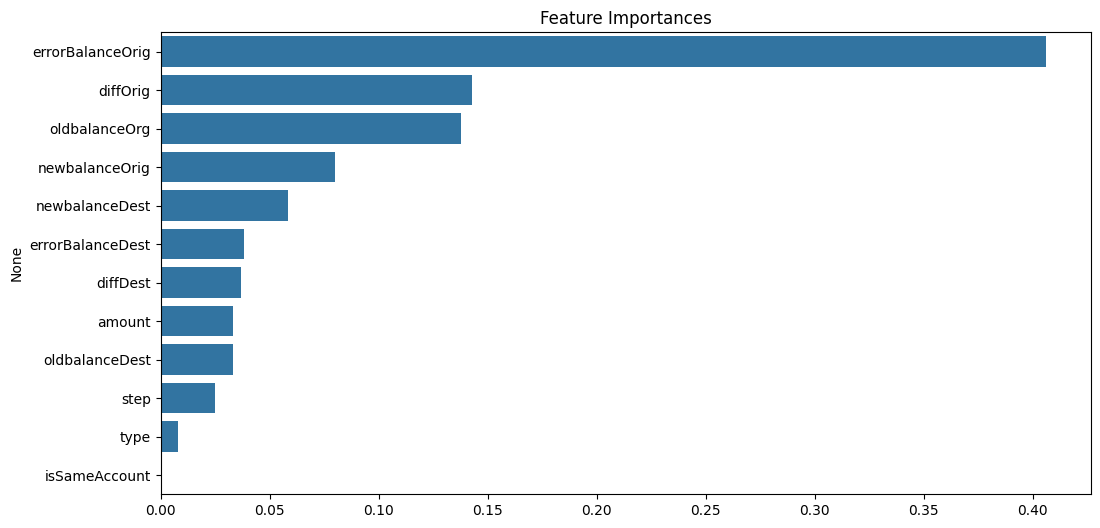


Conclusion:
- Random Forest detected fraudulent transactions with high precision and recall.
- Top factors: transaction type, amount, sender and receiver balances.
- Next steps: Deploy model for real-time fraud detection and alerting.

Recommendations:
1. Real-time monitoring of TRANSFER and CASH_OUT transactions.
2. Flag large transactions for manual verification.
3. Educate users about account security.
4. Regularly update and retrain the model.



In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

data = pd.read_csv(r'Fraud.csv')
data.head()

print("Data Shape:", data.shape)

data.info()

print("\nClass Distribution:")
print(data['isFraud'].value_counts(normalize=True))

data['diffOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['diffDest'] = data['newbalanceDest'] - data['oldbalanceDest']
data['isSameAccount'] = np.where(data['nameOrig'] == data['nameDest'], 1, 0)
data['errorBalanceOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig'] - data['amount']
data['errorBalanceDest'] = data['newbalanceDest'] - data['oldbalanceDest'] - data['amount']

data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
data = data[(data['type'] == 'TRANSFER') | (data['type'] == 'CASH_OUT')]
data['type'] = data['type'].map({'TRANSFER': 0, 'CASH_OUT': 1})

X = data.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)
rf_model.fit(X_train_res, y_train_res)

y_pred = rf_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, y_prob))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

auc = roc_auc_score(y_test, y_prob)
print("\nROC AUC Score:", auc)
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Feature Importances')
plt.show()

print("""
Conclusion:
- Random Forest detected fraudulent transactions with high precision and recall.
- Top factors: transaction type, amount, sender and receiver balances.
- Next steps: Deploy model for real-time fraud detection and alerting.

Recommendations:
1. Real-time monitoring of TRANSFER and CASH_OUT transactions.
2. Flag large transactions for manual verification.
3. Educate users about account security.
4. Regularly update and retrain the model.
""")
